In [1]:
%cd ..

/Users/edvardavagyan/Documents/animate


In [2]:

import torch
import pytorch_lightning as pl
from data.image_folder_dataset import ImageFolderDataset
from processing.XDoG import xdog
from processing.transforms import RandomSketch, Sketch
from data.image_data_module import ImageDataModule
from networks.modules import SketchColoringModule
import matplotlib.pyplot as plt
import numpy as np

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.utilities.model_summary import _format_summary_table, summarize

import os

%load_ext autoreload
%autoreload

In [3]:
# Declare some variables
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

DATASET_PATH = 'portraits/'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
VGG_LAYER_PERCEPTUAL_LOSS = 35 # for conv5_3

## Some dataset demonstration and initial view

In [4]:
portraits = ImageFolderDataset(path=DATASET_PATH)

0.98 200 -0.1 1.6 0.8210100660803852
0.98 200 -0.1 1.6 0.7777917181398748
0.98 200 -0.1 1.6 0.7991604833185249
0.98 200 -0.1 1.6 0.6927157296818988


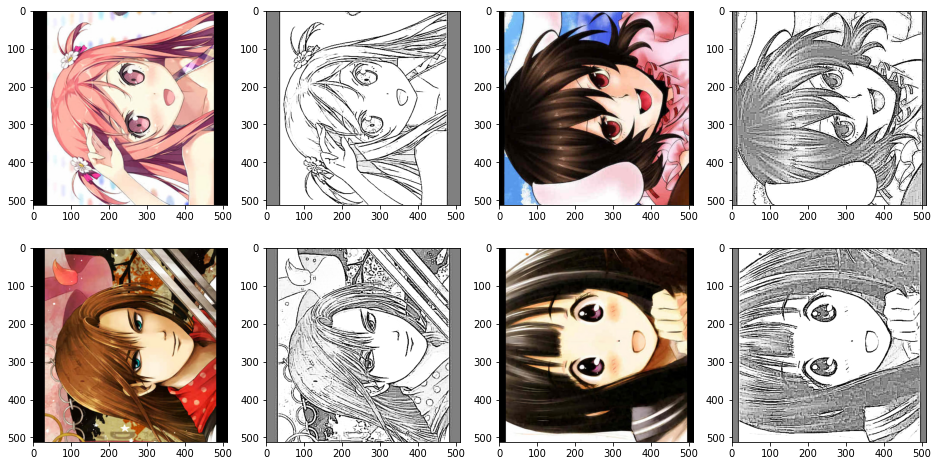

In [5]:
# plot some data samples
samples = [portraits[0], portraits[1], portraits[2], portraits[3]]
w=10
h=10
fig=plt.figure(figsize=(16, 8))
columns = 4
rows = 2
num = 1
for i in range(0, 4):
  img = samples[i][0].transpose(0, 2)
  sketch = samples[i][1].transpose(0, 2)
  fig.add_subplot(rows, columns, num)
  plt.imshow(img)
  fig.add_subplot(rows, columns, num + 1)
  plt.imshow(sketch, cmap="gray")
  num = num + 2
plt.show()

In [6]:
# exploring XDOG filter for sketch generation
default_params = [0.98, 200, -0.1, 1.6, 0.8, False]
test_params = [0.98, 200, -0.1, 1.6, 0.8, False]
xdog_test = ImageFolderDataset(path=DATASET_PATH, sketch_params=test_params)

0.98 200 -0.1 1.6 1.5764388981169666
0.98 200 -0.1 1.6 0.901489361085188
0.98 200 -0.1 1.6 1.3070438853799566
0.98 200 -0.1 1.6 0.8836155965843593


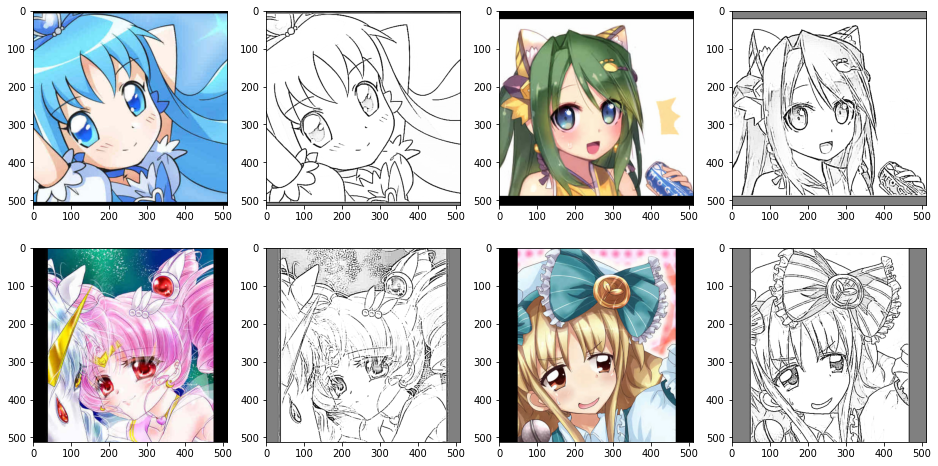

In [7]:
samples = [xdog_test[50], xdog_test[600], xdog_test[700], xdog_test[800]]
w=10
h=10
fig=plt.figure(figsize=(16, 8))
columns = 4
rows = 2
num = 1
for i in range(0, 4):
  img = samples[i][0].permute(1, 2, 0)
  sketch = samples[i][1].permute(1, 2, 0)
  fig.add_subplot(rows, columns, num)
  plt.imshow(img)
  fig.add_subplot(rows, columns, num + 1)
  plt.imshow(sketch, cmap="gray")
  num = num + 2
plt.show()

## Training Setup

In [8]:
data_module = ImageDataModule(data_dir=DATASET_PATH, batch_size=2)
data_module.setup()

In [9]:
# Defining network hpyeprapameters here. Hyperparameters can include anything and will be saved in model checkpoints
# These hyperparameters will be avaialable in the neural network module.

# UNet encoder and decoder dimensions
# !!! Output and bottleneck are automatically added in the code.
colorizer_params = {
  'encoder_blocks': [
    {'in_c': 1, 'out_c': 32},
    {'in_c': 32, 'out_c': 64},
    {'in_c': 64, 'out_c': 128},
    {'in_c': 128, 'out_c': 256},
  ],
  'decoder_blocks': [
    {'in_c': 512, 'out_c': 256},
    {'in_c': 256, 'out_c': 128},
    {'in_c': 128, 'out_c': 64},
    {'in_c': 64, 'out_c': 32},
  ]
}

style_params = {
  'encoder_blocks': [
    {'in_c': 3, 'out_c': 32},
    {'in_c': 32, 'out_c': 64},
    {'in_c': 64, 'out_c': 128},
    {'in_c': 128, 'out_c': 256},
  ],
}

discriminator_params = {
  'encoder_blocks': [
    {'in_c': 3, 'out_c': 32},
    {'in_c': 32, 'out_c': 64},
  ],
}

hparams = {
  "colorizer_params": colorizer_params,
  "discriminator_params": discriminator_params,
  "style_params": style_params,
  "num_exemplars": 2,
  "train_gan": False,
  "g": 1,
  "rec": 1,
  "perc": 1,
  "colorizer_lr": 1e-3,
  "discriminator_lr": 1e-3,
  "b1": 0.9,
  "b2": 0.99,
  "weight_decay": 1e-5,
}

In [10]:
model = SketchColoringModule(device=device, **hparams).float()

In [11]:
print(model)

SketchColoringModule(
  (Generator): SketchColorizer(
    (colorizer_encoder): ModuleList(
      (0): UNetEncoderBlock(
        (conv): ConvBlock(
          (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      )
      (1): UNetEncoderBlock(
        (conv): ConvBlock(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchN

In [18]:
#summarize(model, max_depth=-1)
a = model.forward(torch.rand((1, 1, 512, 512)), torch.rand((1, 3, 512, 512)))

Skip iteration:  1
Saved shape:  1 256 32 32
Skip shape:  torch.Size([1, 256, 64, 64])
Skip iteration:  2
Saved shape:  1 256 32 32
Skip shape:  torch.Size([1, 128, 128, 128])
Skip iteration:  3
Saved shape:  1 256 32 32
Skip shape:  torch.Size([1, 64, 256, 256])
Skip iteration:  4
Saved shape:  1 256 32 32
Skip shape:  torch.Size([1, 32, 512, 512])


In [20]:
rec_loss = model.reconstruction_loss(a, torch.zeros_like(a))
perc_loss = model.perceptual_loss(a, torch.zeros_like(a))

total_loss = rec_loss + perc_loss

total_loss

tensor(0.1242, grad_fn=<AddBackward0>)

In [21]:
total_loss.backward()

In [ ]:
# Load tensorboard to view visualisations realtime during training
%load_ext tensorboard
%tensorboard --logdir lightning_logs

In [22]:
''' 
Pytorch Lightning provides a Trainer class which handles training loop.
The trainer automatically performs validation and training steps while also
logging key metrics which enables effective training.

The trainer takes in data modules and a model and automatically sets up the training loop

The trainier automatically handles GPU or TPU training without the need of
manually casting tensors to device.

The trainer saves model checkpoints so that best models can later be recovered

The trainer supports wide variety of options which make model training more efficient
and fast (16 bit precision, debugging, early stopping, etc.)

Full manual can be found here: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html
'''
# Getting a warning about ambigous batch size
# The warning is nothing serious, it happens because pytorch lightning
# does not handle dictionaries as data inputs well. In reality training loop
# works properly

# Warning: https://github.com/PyTorchLightning/pytorch-lightning/issues/10349 
import warnings
warnings.filterwarnings('ignore')

classifier_logger = TensorBoardLogger(save_dir='lightning_logs', log_graph = True)

checkpoint_callback = ModelCheckpoint(
  monitor="val_loss",
  dirpath="models/",
  filename="colorizer",
  save_top_k=1,
  mode="min",
)

trainer = pl.Trainer(
  overfit_batches=1, # debug option, overfits the given proportion of the whole data
  track_grad_norm=2, # debug option, tracks gradient norms in tensorboard
  default_root_dir=os.getcwd(), # The directory to save and log training results
  max_epochs=30,
  gpus=1 if torch.cuda.is_available() else None, # Uncomment to use GPU training when available
  val_check_interval=0.1, # validate 10 times per epoch, frequent validation is helpful
  logger=classifier_logger, # Logger options to track training
  callbacks=[EarlyStopping(monitor="val_loss", patience=10), checkpoint_callback],
  # checkpoint_callback=False, # toggles checkpointing, might be good to avoid when debugging
  # precision=16, # enable 16 bit precision. Allows multiple times faster training. Works only on GPU so far
)

trainer.fit(model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Skip iteration:  1
Saved shape:  tensor(1) tensor(256) tensor(32) tensor(32)
Skip shape:  torch.Size([1, 256, 64, 64])
Skip iteration:  2
Saved shape:  tensor(1) tensor(256) tensor(32) tensor(32)
Skip shape:  torch.Size([1, 128, 128, 128])
Skip iteration:  3
Saved shape:  tensor(1) tensor(256) tensor(32) tensor(32)
Skip shape:  torch.Size([1, 64, 256, 256])
Skip iteration:  4
Saved shape:  tensor(1) tensor(256) tensor(32) tensor(32)
Skip shape:  torch.Size([1, 32, 512, 512])
Skip iteration:  1
Saved shape:  tensor(1) tensor(256) tensor(32) tensor(32)
Skip shape:  torch.Size([1, 256, 64, 64])
Skip iteration:  2
Saved shape:  tensor(1) tensor(256) tensor(32) tensor(32)
Skip shape:  torch.Size([1, 128, 128, 128])
Skip iteration:  3
Saved shape:  tensor(1) tensor(256) tensor(32) tensor(32)
Skip shape:  torch.Size([1, 64, 256, 256])
Skip iteration:  4
Saved shape:  tensor(1) tensor(256) tensor(32) tensor(32)
Skip shape:  torch.Size([1, 32, 512, 512])
Skip iteration:  1
Saved shape:  1 256 3


  | Name                | Type              | Params | In sizes                             | Out sizes       
--------------------------------------------------------------------------------------------------------------------
0 | Generator           | SketchColorizer   | 8.0 M  | [[1, 1, 512, 512], [1, 3, 512, 512]] | [1, 3, 512, 512]
1 | reconstruction_loss | SmoothL1Loss      | 0      | ?                                    | ?               
2 | adversarial_loss    | BCELoss           | 0      | ?                                    | ?               
3 | perceptual_loss     | PerceptualLossVgg | 20.0 M | ?                                    | ?               
--------------------------------------------------------------------------------------------------------------------
28.0 M    Trainable params
0         Non-trainable params
28.0 M    Total params
112.190   Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]Skip iteration:  1
Saved shape:  4 256 32 32
Skip shape:  torch.Size([4, 256, 64, 64])
Skip iteration:  2
Saved shape:  4 256 32 32
Skip shape:  torch.Size([4, 128, 128, 128])
Skip iteration:  3
Saved shape:  4 256 32 32
Skip shape:  torch.Size([4, 64, 256, 256])
Skip iteration:  4
Saved shape:  4 256 32 32
Skip shape:  torch.Size([4, 32, 512, 512])


TypeError: Input tensor should be a torch tensor. Got <class 'NoneType'>.

In [20]:
data_module.setup()

TypeError: cannot unpack non-iterable NoneType object

In [23]:
l = []
l.append(1)
l

[1]

In [14]:
a = torch.rand((8, 256, 32, 32))
a.shape

torch.Size([8, 256, 32, 32])

In [15]:
b, c, h, w = a.shape
a.view((b, h*w, c))
a.shape

torch.Size([8, 256, 32, 32])

In [12]:
a = torch.rand((1, 1024, 512))
a = a.reshape((1, 512, 32, 32))
print(a.shape)

torch.Size([1, 512, 32, 32])


In [17]:
model.Generator.colorizer_decoder

ModuleList(
  (0): UNetDecoderBlock(
    (up): ConvTranspose2d(512, 128, kernel_size=(2, 2), stride=(2, 2))
    (conv): ConvBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (1): UNetDecoderBlock(
    (up): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (conv): ConvBlock(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL